# Spatial profiles along slit from FORS1 spectra

I would like to achieve the following:

1. [X] Identify W 3 and the bow shock in the spectra
2. [ ] Trace the full western extent of the bow shock in [Ar IV]
    - the MUSE field extends only 22 arcsec from the star
    - the FORS1 spectrum shows a roughly linear ramp that extends about 34 arcsec (see image below)
3. [ ] Calculate the [O III] 4363/5007 temperature profile of the bow shock
    - See if there is any evidence for temperatures as high as the [Ar IV] temperature
4. [ ] Measure the [Ne III] 3869 profile.  Ne$^+$ has the same ionization potential as Ar$^{+2}$ (40 eV), but [Ne III] seems to be much more broadly distributed than [Ar IV]



![FORS1 profile of Ar IV](assets/ngc346-screenshot-fors1-ariv-profile.png)



In [1]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import regions
from astropy.io import fits
from astropy.wcs import WCS
import sys

sys.path.append("../lib")
import extract

sns.set_context("talk")
sns.set_color_codes()

Load line and continuum images for the two blue spectral ranges.  We may use the continuum for masking out regions that have excessive stellar contamination.

In [2]:
hdu1 = fits.open("../data/ngc346-fors1-A-3500-4600-contsub.fits")[0]
hdu2 = fits.open("../data/ngc346-fors1-A-4400-6000-contsub.fits")[0]
hdu1c = fits.open("../data/ngc346-fors1-A-3500-4600-cont.fits")[0]
hdu2c = fits.open("../data/ngc346-fors1-A-4400-6000-cont.fits")[0]

In [3]:
hdu1B = fits.open("../data/ngc346-fors1-B-3562-4600-contsub.fits")[0]
hdu2B = fits.open("../data/ngc346-fors1-B-4400-6000-contsub.fits")[0]
hdu1cB = fits.open("../data/ngc346-fors1-B-3562-4600-cont.fits")[0]
hdu2cB = fits.open("../data/ngc346-fors1-B-4400-6000-cont.fits")[0]

Set up the world coords for the two ranges

In [4]:
wcs1 = WCS(hdu1)
wcs2 = WCS(hdu2)
wcs1B = WCS(hdu1B)
wcs2B = WCS(hdu2B)

Set up the lines that we want with wavelength limits:

In [5]:
restwav = {
    "He II 4686": 4685.68,
    "[Ar IV] 4740": 4740.17,
    "[O III] 5007": 5006.84,
    "[O III] 4363": 4363.209,
    "[Ne III] 3869": 3869.07,
    "H I 4861": 4861.32,
    "H I 4340": 4340.463,
    "H I 4102": 4101.735,
}

In [6]:
vsys = 160.0
vlim = np.array([50.0, 400.0])
restwav["He II 4686"] * (1.0 + vlim / 3e5)
restwav["[O III] 5007"] * (1.0 + vlim / 3e5)

array([5007.67447333, 5013.51578667])

In [15]:
def extract_line(wav0, pvim, wcs, vlim=[-50, 500]):
    wavrange = wav0 * (1.0 + np.array(vlim) / 3e5)
    imwin, ww = extract.pvslice(pvim, wcs, wavrange, None)
    return imwin.sum(axis=1)

In [16]:
sA = {}
for label, wav0 in restwav.items():
    pvim, wcs = (hdu2.data, wcs2) if wav0 > 4400.0 else (hdu1.data, wcs1)
    sA[label] = extract_line(wav0, pvim, wcs)

In [17]:
sA

{'He II 4686': array([ 4.91798   ,  2.6666002 , 10.211499  , ..., -6.021369  ,
         6.8706064 , -0.31045628], dtype=float32),
 '[Ar IV] 4740': array([-1.792285 ,  6.31734  , -7.1055946, ..., 13.920408 ,  1.6577568,
        -4.368843 ], dtype=float32),
 '[O III] 5007': array([ 962.9935,  937.1786,  948.5851, ..., 2678.785 , 2686.6885,
        2575.8247], dtype=float32),
 '[O III] 4363': array([ 9.781406 , 25.337358 ,  3.103735 , ..., 23.458693 , 38.40285  ,
        -6.2827263], dtype=float32),
 '[Ne III] 3869': array([209.94693, 172.75098, 241.46529, ..., 424.67783, 390.39307,
        419.36307], dtype=float32),
 'H I 4861': array([358.6066 , 381.50922, 354.6538 , ..., 477.38068, 486.5985 ,
        457.91428], dtype=float32),
 'H I 4340': array([148.78241, 139.60486, 149.39503, ..., 218.55136, 224.57607,
        218.40974], dtype=float32),
 'H I 4102': array([ 94.91426 , 117.06179 ,  65.610306, ..., 188.67993 , 181.79878 ,
        148.10866 ], dtype=float32)}

In [18]:
sB = {}
for label, wav0 in restwav.items():
    pvim, wcs = (hdu2B.data, wcs2B) if wav0 > 4400.0 else (hdu1B.data, wcs1B)
    sB[label] = extract_line(wav0, pvim, wcs)

In [19]:
ny = len(sA["He II 4686"])
_, posA = wcs1.pixel_to_world_values(
    [0] * ny,
    np.arange(ny),
)
ny = len(sB["He II 4686"])
_, posB = wcs1.pixel_to_world_values(
    [0] * ny,
    np.arange(ny),
)
posA *= -1.0
posB *= -1.0

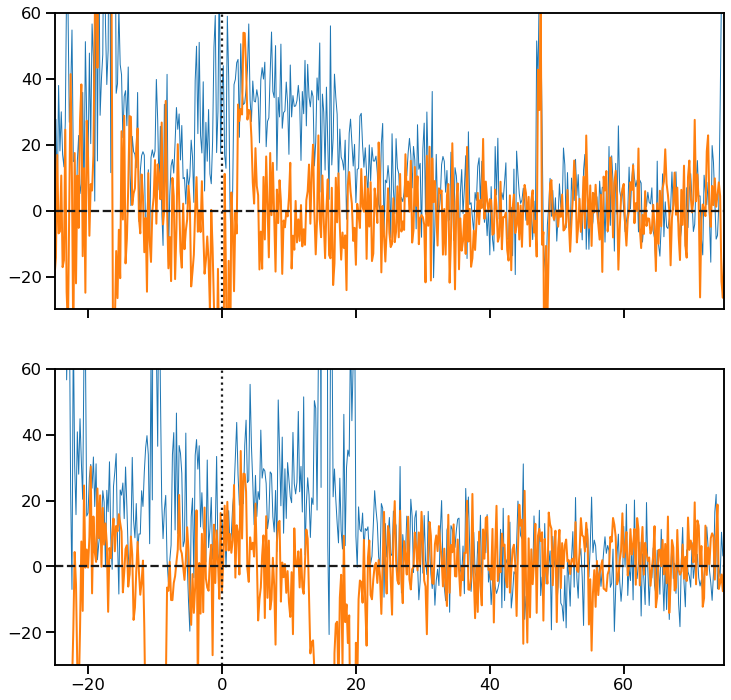

In [20]:
fig, axes = plt.subplots(
    2,
    1,
    figsize=(12, 12),
    sharex=True,
)
axes[0].plot(posA, sA["[Ar IV] 4740"], linewidth=1.0, alpha=1.0)
axes[0].plot(posA, sA["He II 4686"], linewidth=2.0, alpha=1.0)
axes[0].axhline(0.0, linestyle="dashed", color="k")
axes[0].axvline(0.0, linestyle="dotted", color="k")

axes[1].plot(posB, sB["[Ar IV] 4740"], linewidth=1.0, alpha=1.0)
axes[1].plot(posB, sB["He II 4686"], linewidth=2.0, alpha=1.0)
axes[1].axhline(0.0, linestyle="dashed", color="k")
axes[1].axvline(0.0, linestyle="dotted", color="k")

for ax in axes:
    ax.set(
        xlim=[-25, 75],
        ylim=[-30, 60],
    )

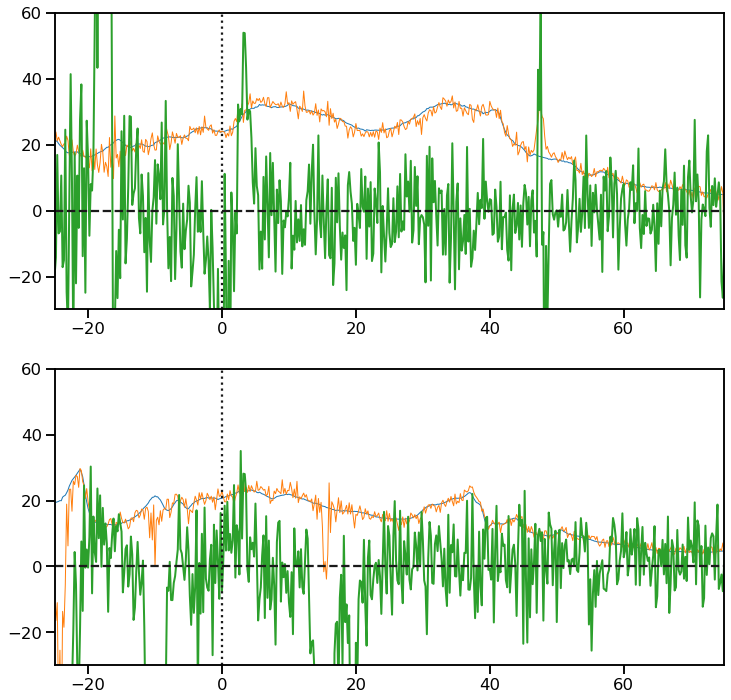

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
axes[0].plot(posA, 1e-3 * sA["[O III] 5007"], linewidth=1.0, alpha=1.0)
axes[0].plot(posA, 0.075 * sA["[O III] 4363"], linewidth=1.0, alpha=1.0)
axes[0].plot(posA, sA["He II 4686"], linewidth=2.0, alpha=1.0)
axes[1].plot(posB, 1e-3 * sB["[O III] 5007"], linewidth=1.0, alpha=1.0)
axes[1].plot(posB, 0.075 * sB["[O III] 4363"], linewidth=1.0, alpha=1.0)
axes[1].plot(posB, sB["He II 4686"], linewidth=2.0, alpha=1.0)

for ax in axes:
    ax.axhline(0.0, linestyle="dashed", color="k")
    ax.axvline(0.0, linestyle="dotted", color="k")
    ax.set(
        xlim=[-25, 75],
        ylim=[-30, 60],
    )

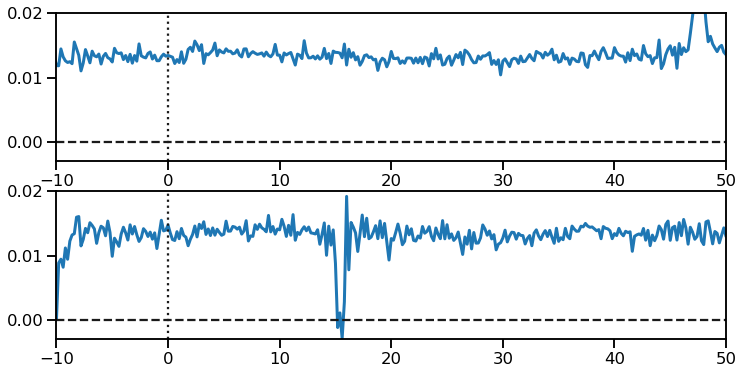

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
for ax, pos, s in zip(axes, [posA, posB], [sA, sB]):
    ax.plot(pos, s["[O III] 4363"] / s["[O III] 5007"], linewidth=3.0, alpha=1.0)
    ax.plot(pos, 0.0003 * s["[O III] 5007"], linewidth=2.0, alpha=1.0)
    ax.axhline(0.0, linestyle="dashed", color="k")
    ax.axvline(0.0, linestyle="dotted", color="k")
    ax.set(
        xlim=[-10, 50],
        ylim=[-0.003, 0.02],
    )

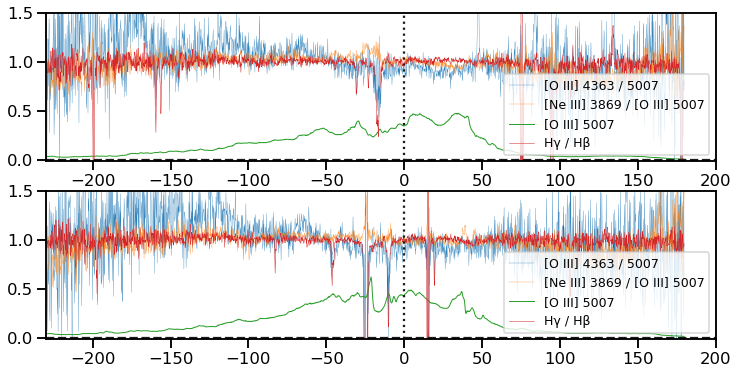

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
for ax, pos, s in zip(axes, [posA, posB], [sA, sB]):
    ax.plot(
        pos,
        s["[O III] 4363"]
        / s["[O III] 5007"]
        / np.median(s["[O III] 4363"] / s["[O III] 5007"]),
        linewidth=0.3,
        alpha=1.0,
        label="[O III] 4363 / 5007",
    )
    ax.plot(
        pos,
        s["[Ne III] 3869"]
        / s["[O III] 5007"]
        / np.median(s["[Ne III] 3869"] / s["[O III] 5007"]),
        linewidth=0.3,
        alpha=1.0,
        label="[Ne III] 3869 / [O III] 5007",
    )
    ax.plot(
        pos,
        0.1 * s["[O III] 5007"] / np.median(s["[O III] 5007"]),
        #    0.1* s4341 / np.median(s4341),
        linewidth=1.0,
        alpha=1.0,
        label="[O III] 5007",
    )
    ax.plot(
        pos,
        s["H I 4340"] / s["H I 4861"] / np.median(s["H I 4340"] / s["H I 4861"]),
        linewidth=0.5,
        alpha=1.0,
        label="Hγ / Hβ",
    )
    # ax.plot(positions, 0.0003 * s4686, linewidth=2.0, alpha=1.0)
    ax.axhline(0.0, linestyle="dashed", color="k")
    ax.axvline(0.0, linestyle="dotted", color="k")

    ax.legend(fontsize="x-small")
    ax.set(
        # xlim=[-10, 50],
        xlim=[-230, 200],
        ylim=[-0.01, 1.5],
    )

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
hb_hg = s4861 / s4341
hg_hd = s4341 / s4102

ax.scatter(hb_hg, hg_hd, s=300, linewidth=0, alpha=0.1, marker=".")
ax.set(
    xlim=[1.5, 2.5],
    ylim=[1.0, 2.0],
)